# **Importation du Dataset**

In [1]:
import numpy as np
from keras.datasets.mnist import load_data

(X_train, Y_train), (X_test, Y_test) = load_data()
print(f'Nombre d\'éléments dans l\'entraînement: {len(X_train)}')
print(f'Nombre d\'éléments dans le test: {len(X_test)}')
mean = X_train.max() / 2
X_train = (np.float32(X_train) - mean) / mean

2024-06-17 10:29:39.613578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 10:29:39.667202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:29:39.667251: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:29:39.667280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 10:29:39.676448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 10:29:39.677242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Nombre d'éléments dans l'entraînement: 60000
Nombre d'éléments dans le test: 10000


# **Implémentation de notre Dataset**

In [2]:
from PIL import Image
from typing import List, Callable

class Compose(object):
    """Classe pour encapsuler des transformations d'images."""
    def __init__(self, transforms: List[Callable]):
        """
        Initialise la classe Compose avec une liste de transformations.
        """
        self.transforms = transforms

    def __call__(self, image: Image.Image) -> Image.Image:
        """
        Applique séquentiellement les transformations à une image.
        """
        for t in self.transforms:
            image = t(image)
        return image

In [3]:
import torch
import random as rd
from typing import Tuple, Optional, Dict

class Dataset(torch.utils.data.Dataset):
    """Classe Dataset pour un modèle de type GAN."""
    def __init__(self,  dataset: List[Dict], transform: Optional[Callable]):
        """
        Initialise la classe Dataset.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index) -> torch.Tensor:
        """
        Obtient un exemplaire de la base de données à partir de son indice et de sa représentation/labellisation tensorielle par le modèle.
        """
        image = Image.fromarray(self.dataset[index])

        if self.transform:
            image = self.transform(image)
        
        return image.flatten()

# **Générateur**

In [4]:
# (caractéristiques, neurones)
"""generator_architecture = [(100, 128),
                          'ReLU',
                          (128, 256),
                          'ReLU',
                          (256,512),
                          'ReLU',
                          (512, 1024),
                          'ReLU',
                          (1024, 28*28),
                          'Tanh']"""

generator_architecture = [(100, 1200),
                          'ReLU',
                          (1200, 1200),
                          'ReLU',
                          (1200, 28*28),
                          'Tanh']

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    """
    Générateur d'images.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.network = self._create_network(generator_architecture)

    def forward(self, noise):
        return self.network(noise)
    
    def _create_network(self, architecture):
        layers = []
        for element in architecture:
            if type(element) == tuple:
                layers.append(nn.Linear(element[0], element[1]))

            elif type(element) == str:
                try:
                    activation_function = getattr(nn, element)
                    layers.append(activation_function())
                except AttributeError:
                    print(f'Fonction d\'activation non présente dans la classe {nn}: ', element)
        return nn.Sequential(*layers)


# **Discriminateur**

In [6]:
"""# (caractéristiques, neurones)
discriminator_architecture = [(28*28, 128),
                          'LeakyReLU',
                          (128, 256),
                          'LeakyReLU',
                          (256,512),
                          'LeakyReLU',
                          (512, 512),
                          'LeakyReLU',
                          (512, 256),
                          'LeakyReLU',
                          (256, 128),
                          'LeakyReLU',
                          (128, 1),
                          'Sigmoid']"""

# (caractéristiques, neurones)
discriminator_architecture = [(28*28, 240),
                          'LeakyReLU',
                          (240, 240),
                          'LeakyReLU',
                          (240, 1),  
                          'Sigmoid']

In [7]:
class Discriminator(nn.Module):
    """
    Discriminateur d'images.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = self._create_network(discriminator_architecture)

    def forward(self, x):
        return self.network(x)
    
    def _create_network(self, architecture):
        layers = []
        for element in architecture:
            if type(element) == tuple:
                layers.append(nn.Linear(element[0], element[1]))

            elif type(element) == str:
                try:
                    activation_function = getattr(nn, element)
                    layers.append(activation_function())
                except AttributeError:
                    print(f'Fonction d\'activation non présente dans la classe {nn}: ', element)
        return nn.Sequential(*layers)

# **Train**

In [8]:
def noise(batch_size: int, dim):
    out = torch.empty(batch_size, dim)
    mean = torch.zeros(batch_size, dim)
    std = torch.ones(dim)
    out = torch.normal(mean, std, out=out)
    return out

In [18]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_fn(loader: DataLoader, generator: nn.Module, discriminator: nn.Module, goptimizer: optim, doptimizer:optim, device: str):
    """
    Entraîne le modèle.

    Parameters:

    Returns:
    """
    generator.train()
    discriminator.train()

    loop = tqdm(loader, leave=True)

    dmean_loss = []
    for x in loop:
        x = x.to(device)
        z = noise(loader.batch_size, dim=100)
        z = z.to(device)
        f_loss = torch.nn.BCELoss()(discriminator(generator(z)).reshape(loader.batch_size), torch.zeros(loader.batch_size, device=device))
        r_loss = torch.nn.BCELoss()(discriminator(x).reshape(loader.batch_size), torch.ones(loader.batch_size, device=device))
        loss = (r_loss + f_loss) / 2
        doptimizer.zero_grad()
        loss.backward()
        doptimizer.step()
        dmean_loss.append(loss.item())

        loop.set_postfix(dloss=loss.item())

    dmean_loss = sum(dmean_loss) / len(dmean_loss)

    z = noise(loader.batch_size, dim=100).to(device)
    g = generator(z)
    loss = torch.nn.BCELoss()(discriminator(g).reshape(loader.batch_size), torch.ones(loader.batch_size, device=device))
    goptimizer.zero_grad()
    loss.backward()
    goptimizer.step()

    print(g.shape)
    plt.axis('off')
    plt.imshow(g[0].data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.show()

    return dmean_loss, loss.item()

# **Main**

1/50:


100%|██████████| 600/600 [00:22<00:00, 26.49it/s, dloss=2.82e-5] 


torch.Size([100, 784])


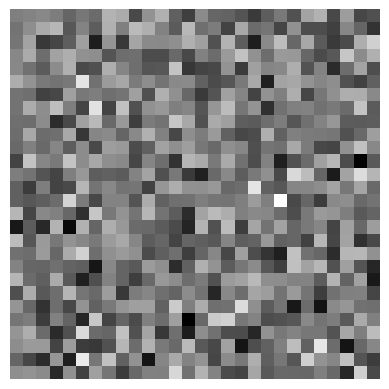

DLoss = 0.004451846005219219 | GLoss = 9.818951606750488
2/50:


 51%|█████     | 304/600 [02:30<02:28,  1.99it/s, dloss=1.03e-25]

In [19]:
import os
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import MultiStepLR

# Hyperparamètres Entraînement
EPOCHS = 50
LEARNING_RATE = 0.5
MILESTONES = [10]
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 100
SIZE = 28

# Hyperparamètres Dataset/Dataloader
NUM_WORKERS = os.cpu_count()
PIN_MEMORY = True
SHUFFLE = True
DROP_LAST = True

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    # Optimiseur
    doptimizer = optim.SGD(discriminator.parameters(), lr=LEARNING_RATE, momentum=0.5)
    goptimizer = optim.SGD(generator.parameters(), lr=LEARNING_RATE, momentum=0.5)


    # Pas variant en fonction des epochs
    dscheduler = MultiStepLR(doptimizer, milestones=MILESTONES, gamma=0.1)
    gscheduler = MultiStepLR(goptimizer, milestones=MILESTONES, gamma=0.1)

    # Transformateur: transforme les images et les vecteurs label_matrix en tenseur
    transform = Compose([transforms.Resize((SIZE, SIZE)), transforms.ToTensor(),])
    
    train_dataset = Dataset(X_train, transform)
    loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=SHUFFLE,
    drop_last=DROP_LAST)

    dmean_loss = []
    gmean_loss = []
    # Apprentissage
    
    for epoch in range(1, EPOCHS+1):
        print(f'{epoch}/{EPOCHS}:')
        dloss, gloss = train_fn(loader, generator, discriminator, goptimizer, doptimizer, device)
        print(f'DLoss = {dloss} | GLoss = {gloss}')
        
        dmean_loss.append(dloss)
        gmean_loss.append(gloss)

        dscheduler.step()
        gscheduler.step()

    plt.plot(dmean_loss)
    plt.plot(gmean_loss)
    plt.show()

    NB_IMAGES = 25
    z = noise(NB_IMAGES, dim=100).to(device)
    x = generator(z)
    plt.figure(figsize=(17, 17))
    for i in range(NB_IMAGES):
        plt.subplot(5, 5, 1 + i)
        plt.axis('off')
        plt.imshow(x[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.show()